In [1]:
from skimage.filters import gabor_kernel
from skimage import io
from skimage.transform import resize
from matplotlib import pyplot as plt 
import numpy as np

import math

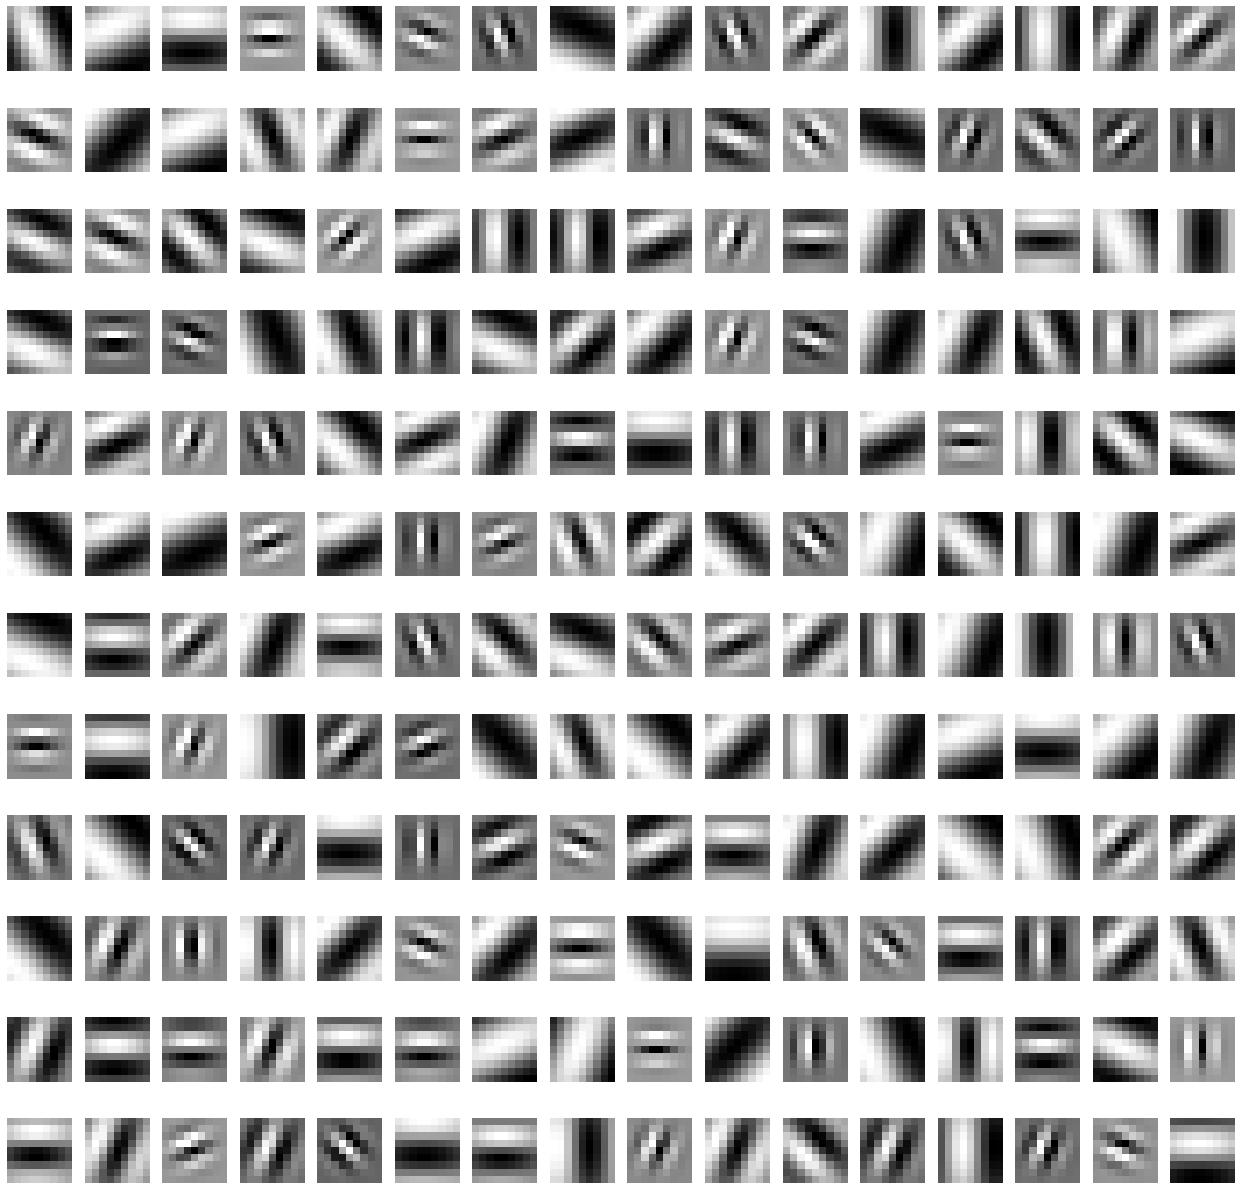

In [2]:
def get_gabor_filters(inchannels, outchannels, kernel_size = (3,3)):
    delta = 1e-4
    freqs = (math.pi/2)*math.sqrt(2)**(-np.random.randint(0,5, (outchannels, inchannels)))
    thetas = (math.pi/8)*np.random.randint(0,8, (outchannels, inchannels))
    sigmas = math.pi/freqs
    psis = math.pi * np.random.rand(outchannels, inchannels)
    x0, y0 = np.ceil(np.array(kernel_size)/2)    
    
    y, x = np.meshgrid(
            np.linspace(-x0 + 1, x0 + 0, kernel_size[0]),
            np.linspace(-y0 + 1, y0 + 0, kernel_size[1]),
    )
    filterbank = []
    
    for i in range(outchannels):
        for j in range(inchannels):
            freq = freqs[i][j]
            theta = thetas[i][j]
            sigma = sigmas[i][j]
            psi = psis[i][j]
            
            rotx = x * np.cos(theta) + y * np.sin(theta)
            roty = -x * np.sin(theta) + y * np.cos(theta)

            g = np.exp(
                -0.5 * ((rotx ** 2 + roty ** 2) / (sigma + delta) ** 2)
            )
            g = g * np.cos(freq * rotx + psi)
            g = g / (2 * math.pi * sigma ** 2)
            filterbank.append(g)
    return filterbank

filterbank = get_gabor_filters(3, 64, (9,9))

fig = plt.subplots(12, 16, figsize=(22,22))
for i,gf in enumerate(filterbank):
    plt.subplot(12, 16, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')

In [3]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)


In [4]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam

input_dim = (32,32,3)
input_img = Input(shape=input_dim)

cl1 = Conv2D(64, kernel_size=(9,9), strides=(1,1), padding='same',
             input_shape=input_dim, activation='relu')(input_img)
pl1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(cl1)

cl2 = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same',
             activation='relu')(pl1)
pl2 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(cl2)

cl3 = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same',
             activation='relu')(pl2)
pl3 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(cl3)

cl4 = Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same',
             activation='relu')(pl3)
pl4 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(cl4)

cl5 = Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same',
             activation='relu')(pl4)
pl5 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(cl5)

flat = Flatten()(pl5)

fc6 = Dense(units=4096, activation='relu')(flat)
fc7 = Dense(units=4096, activation='relu')(fc6)

output = Dense(units=10, activation='softmax')(fc7)

classifier = Model(input_img, output)

# Compiling the CNN
opt = RMSprop(learning_rate=0.001)
# opt = Adam(learning_rate=0.01)

classifier.compile(optimizer = opt, loss = 'binary_crossentropy', 
                   metrics = ['accuracy'])

print(classifier.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        15616     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)        

In [6]:
cnnl1 = classifier.layers[1].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape

gabor_filters = np.empty(wshape, dtype='float32')
for kernel_index in range(wshape[3]):
    for channel_index in range(3):
        gabor_filters[:,:,channel_index, kernel_index] = filterbank[kernel_index+channel_index]

cnnl1 = classifier.layers[1].name   # get the name of the first conv layer
classifier.get_layer(name=cnnl1).set_weights([gabor_filters, classifier.get_layer(name=cnnl1).get_weights()[1]])

In [ ]:
# Fitting the CNN to the images

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)

stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)

hist = classifier.fit(x_train, y_train, batch_size=100, epochs=1000, 
                   callbacks=[stop_alg, reduce_lr], shuffle=True, 
                   validation_data=(x_test, y_test))




Epoch 1/1000
500/500 [==============================] - 932s 2s/step - loss: 0.3269 - accuracy: 0.1385 - val_loss: 0.2968 - val_accuracy: 0.2137
Epoch 2/1000
500/500 [==============================] - 927s 2s/step - loss: 0.2630 - accuracy: 0.3511 - val_loss: 0.2378 - val_accuracy: 0.4235
Epoch 3/1000
500/500 [==============================] - 926s 2s/step - loss: 0.2200 - accuracy: 0.4923 - val_loss: 0.2074 - val_accuracy: 0.5368
Epoch 4/1000
500/500 [==============================] - 936s 2s/step - loss: 0.1914 - accuracy: 0.5750 - val_loss: 0.2057 - val_accuracy: 0.5556
Epoch 5/1000
500/500 [==============================] - 936s 2s/step - loss: 0.1689 - accuracy: 0.6302 - val_loss: 0.1918 - val_accuracy: 0.5849
Epoch 6/1000
500/500 [==============================] - 933s 2s/step - loss: 0.1505 - accuracy: 0.6785 - val_loss: 0.1667 - val_accuracy: 0.6462
Epoch 7/1000
500/500 [==============================] - 928s 2s/step - loss: 0.1363 - accuracy: 0.7112 - val_loss: 0.1615 - val_ac